Word2Vec: https://www.kaggle.com/code/vladislavkisin/word2vec-in-supervised-nlp-tasks-shortcut/notebook

In [ ]:
from google.colab import drive
drive.mount(r'/content/drive/', force_remount=True) 


Mounted at /content/drive/


In [1]:
data_dir = '/content/drive/My Drive/Advance ML/Final Project/'
test_csv = data_dir + 'dreaddit-test.csv'
train_csv = data_dir + 'dreaddit-train.csv'

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, Normalizer
from sklearn.feature_selection import SelectKBest, chi2, RFE, VarianceThreshold, mutual_info_classif, SelectKBest

In [3]:
import re
import nltk
nltk.download('punkt')
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from gensim.models import word2vec, Word2Vec

In [5]:
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

FileNotFoundError: ignored

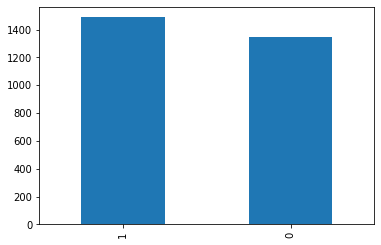

In [ ]:
train_df['label'].value_counts().plot(kind='bar')

In [ ]:
train_df.head()

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1521614353,5,1.806818,...,1.000,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1527009817,4,9.429737,...,1.125,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,1,0.8,1535935605,2,7.769821,...,1.000,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",239,1,0.6,1516429555,0,2.667798,...,1.000,1.1250,1.0,1.75356,1.52114,1.98848,0.50,5,4.104027,0.141671
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1421,1,0.8,1539809005,24,7.554238,...,1.000,1.1250,1.0,1.77644,1.64872,1.81456,1.00,1,7.910952,-0.204167


In [ ]:
values = train_df['subreddit'].value_counts()
labels = train_df['subreddit'].value_counts().index

fig = px.pie(train_df, names=labels, values=values)
fig.update_layout(title='Subreddits distribution')
fig.update_traces(hovertemplate='%{label}: %{value}')
fig.show()

In [ ]:
train_df['subreddit']

0                   ptsd
1             assistance
2                   ptsd
3          relationships
4       survivorsofabuse
              ...       
2833       relationships
2834                ptsd
2835             anxiety
2836      almosthomeless
2837                ptsd
Name: subreddit, Length: 2838, dtype: object

In [ ]:
train_df['subreddit'] = label_enc.fit_transform(train_df['subreddit'])
test_df['subreddit'] = label_enc.fit_transform(test_df['subreddit'])

In [ ]:
train_df['subreddit']

0       6
1       2
2       6
3       7
4       9
       ..
2833    7
2834    6
2835    1
2836    0
2837    6
Name: subreddit, Length: 2838, dtype: int64

Take all the 80% majurity data

In [ ]:
BestData_ = train_df[train_df['confidence'] >= 0.8]

In [ ]:
BestData_.shape

(1852, 116)

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from string import punctuation
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
import re

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop])

def remove_punctuation(text):
    return text.translate(str.maketrans('','', punctuation))

def nospecial(text, remove_spaces=True):
    #return re.sub('[^a-zA-Z0-9 ]', " ", text)
    return re.sub('[^a-zA-Z ]', "", text)

def clean_text(text):
    text = remove_stopwords(text)
    text = remove_punctuation(text)
    text = nospecial(text)
    return text

In [ ]:
# Here we get transform the documents into sentences for the word2vecmodel
# we made a function such that later on when we make the submission, we don't need to write duplicate code
def preprocess(df):
    df['text'] = df['text'].apply(clean_text)
    df['text'] = df.text.str.lower()
    df['document_sentences'] = df.text.str.split('.') 
    df['tokenized_sentences'] = list(map(lambda sentences: list(map(nltk.word_tokenize, sentences)), df.document_sentences))  
    df['tokenized_sentences'] = list(map(lambda sentences: list(filter(lambda lst: lst, sentences)), df.tokenized_sentences))

In [ ]:
preprocess(BestData_)
preprocess(test_df)

In [ ]:
#Collecting a vocabulary
voc = []
for sentence in BestData_.tokenized_sentences:
    voc.extend(sentence)

print("Number of sentences: {}.".format(len(voc)))
print("Number of rows: {}.".format(len(BestData_)))

Number of sentences: 1852.
Number of rows: 1852.


Word2Vec model

In [ ]:
num_features = 260    
min_word_count = 3
num_workers = 4
context = 8
downsampling = 1e-3

# Initialize and train the model
W2Vmodel = Word2Vec(sentences=voc, sg=1, hs=0, workers=num_workers, size=num_features, min_count=min_word_count, window=context,
                    sample=downsampling, negative=5, iter=10)

In [ ]:
def sentence_vectors(model, sentence):
    #Collecting all words in the text
    words=np.concatenate(sentence)
    #Collecting words that are known to the model
    model_voc = set(model.wv.vocab.keys()) 
    sent_vector = np.zeros(model.vector_size, dtype="float32")
    # Use a counter variable for number of words in a text
    nwords = 0
    # Sum up all words vectors that are know to the model
    for word in words:
        if word in model_voc: 
            sent_vector += model[word]
            nwords += 1.

    # Now get the average
    if nwords > 0:
        sent_vector /= nwords
    return sent_vector

In [ ]:
BestData_['sentence_vectors'] = list(map(lambda sen_group: sentence_vectors(W2Vmodel, sen_group), BestData_.tokenized_sentences))
test_df['sentence_vectors'] = list(map(lambda sen_group:sentence_vectors(W2Vmodel, sen_group), test_df.tokenized_sentences))

In [ ]:
def vectors_to_feats(df, ndim):
    index=[]
    for i in range(ndim):
        df[f'w2v_{i}'] = df['sentence_vectors'].apply(lambda x: x[i])
        index.append(f'w2v_{i}')
    return df[index]

In [ ]:
X_train_Word2Vec = vectors_to_feats(BestData_, num_features)
X_test_Word2Vec = vectors_to_feats(test_df, num_features)
X_train_Word2Vec.head()

,w2v_0,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,w2v_9,...,w2v_250,w2v_251,w2v_252,w2v_253,w2v_254,w2v_255,w2v_256,w2v_257,w2v_258,w2v_259
0,0.035087,-0.072923,-0.145408,-0.081377,0.111524,-0.003318,-0.072515,-0.026581,-0.136346,0.006724,...,0.003326,0.007565,-0.128564,0.134916,0.116049,0.175457,-0.170158,0.008249,-0.188696,0.077191
1,-0.021622,-0.078116,-0.102134,-0.044115,0.086928,0.011751,-0.018439,-0.014183,-0.074015,0.024926,...,0.020666,-0.015952,-0.183986,0.140473,0.231992,0.159862,-0.148824,-0.018287,-0.167339,0.131886
2,0.006514,-0.105220,-0.178317,-0.075742,0.100493,0.024273,-0.101532,-0.001933,-0.123259,0.004013,...,-0.017108,0.014691,-0.127427,0.147809,0.145504,0.172626,-0.184392,-0.007046,-0.163304,0.060759
4,-0.024103,-0.099185,-0.163085,-0.077270,0.126656,-0.003010,-0.093129,-0.032988,-0.120552,-0.004677,...,0.024258,0.023921,-0.115765,0.133164,0.109543,0.119501,-0.165931,-0.019525,-0.166813,0.090552
5,0.037063,-0.090980,-0.200373,-0.086178,0.094318,-0.009459,-0.081806,-0.004854,-0.100729,0.018601,...,0.011880,0.007056,-0.135230,0.206080,0.120920,0.193247,-0.197536,0.008477,-0.179473,0.064669


In [ ]:
test_df.head()

,id,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp,social_karma,syntax_ari,...,w2v_250,w2v_251,w2v_252,w2v_253,w2v_254,w2v_255,w2v_256,w2v_257,w2v_258,w2v_259
0,896,7,7nu7as,"[50, 55]",its like that want not me i problem takes long...,0,0.8,1.514981e+09,22,-1.238793,...,-0.008199,0.013065,-0.140107,0.143846,0.155391,0.194600,-0.192354,-0.013527,-0.166994,0.076463
1,19059,1,680i6d,"(5, 10)",i man front desk title hr customer service rep...,0,1.0,1.493348e+09,5,7.684583,...,-0.016371,-0.002031,-0.124508,0.135165,0.171809,0.133652,-0.150884,-0.018058,-0.153327,0.104484
2,7977,6,8eeu1t,"(5, 10)",wed saving much money new housrits expensive c...,1,1.0,1.524517e+09,10,2.360408,...,0.007836,0.024782,-0.118304,0.140640,0.143014,0.160075,-0.197102,-0.022018,-0.165514,0.087107
3,1214,6,8d28vu,"[2, 7]",my ex used shoot back do want go you time matt...,1,0.5,1.524018e+09,5,5.997000,...,-0.015039,0.006160,-0.133646,0.167491,0.128559,0.205062,-0.202513,0.025475,-0.193133,0.067880
4,1965,7,7r1e85,"[23, 28]",i havent said anything yet im sure someone wou...,0,0.8,1.516200e+09,138,4.649418,...,-0.003317,0.001806,-0.131743,0.158590,0.134977,0.184696,-0.193229,0.013644,-0.179989,0.080739


In [ ]:
y_train = BestData_['label']
X_train = BestData_.drop('label', axis=1)

In [ ]:
y_test = test_df['label']
X_test = test_df.drop('label', axis=1)

In [ ]:
X_train = X_train.select_dtypes(include=np.number)

In [ ]:
X_test = X_test.select_dtypes(include=np.number)

In [ ]:
X_train.shape

(1852, 372)

In [ ]:
def best_model(X_train, y_train, X_test, y_test, scaler, algo):
        
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model = algo()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    training_score = model.score(X_train, y_train)
    acc = accuracy_score(y_test, predictions)
    con = confusion_matrix(y_test, predictions)
    report = classification_report(y_test, predictions)
    print(f'Training Score: {training_score}')
    print(f'Accuracy Score: {acc}')
    print(" ")
    print('Confusion Matrix:')
    print(con)
    print(" ")
    print('Classification Report:')
    print(report)

## Pearson correlation method

In [ ]:
def correlation(df, thres): #Dataset and threshold value
    col_corr = set()
    corr_matrix = df.corr(method='pearson')
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) >= thres:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [ ]:
corr_features = correlation(X_train, 0.4)

In [ ]:
len(corr_features)

317

In [ ]:
X_train[corr_features]

,w2v_79,w2v_52,w2v_140,lex_liwc_cogproc,w2v_24,w2v_184,w2v_49,w2v_57,w2v_153,w2v_29,...,w2v_76,w2v_6,w2v_146,w2v_207,w2v_53,lex_liwc_male,w2v_110,lex_liwc_compare,w2v_43,lex_liwc_ipron
0,0.039773,0.087261,0.102450,11.21,0.089171,-0.030482,-0.018495,0.095862,-0.068375,-0.074101,...,-0.121801,-0.072515,0.077582,0.038921,0.180189,1.72,-0.051675,3.45,0.079789,4.31
1,0.119656,0.113525,0.159806,11.93,0.054513,-0.052818,-0.084109,0.072800,-0.020357,-0.067310,...,-0.102577,-0.018439,0.116116,0.076269,0.118489,0.00,-0.081717,0.92,-0.021954,4.59
2,0.030020,0.101828,0.087720,10.18,0.069042,-0.017585,-0.016834,0.104224,-0.075153,-0.051094,...,-0.119776,-0.101532,0.042393,0.033404,0.169010,2.40,-0.041123,0.60,0.071847,8.98
4,0.050418,0.080315,0.105477,11.24,0.099229,-0.020806,-0.021042,0.108458,-0.067955,-0.014893,...,-0.125146,-0.093129,0.026160,-0.005184,0.175192,4.49,-0.070630,2.25,0.065250,4.49
5,0.037661,0.093762,0.112329,15.24,0.052330,-0.004317,0.002495,0.105363,-0.078069,-0.076483,...,-0.129858,-0.081806,0.062191,0.042726,0.168823,3.81,-0.064371,1.90,0.106614,5.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829,0.131231,0.098937,0.096025,5.48,0.074587,-0.018002,-0.045880,0.035831,-0.031617,-0.025884,...,-0.123983,-0.102434,0.040768,0.020666,0.148001,2.74,-0.068199,1.37,0.013387,0.00
2831,0.057583,0.135770,0.065600,8.59,0.064782,0.006147,-0.027607,0.043113,-0.071234,-0.058992,...,-0.114682,-0.113591,0.020955,0.033963,0.174529,3.91,-0.059488,2.34,0.055881,7.03
2833,0.069077,0.066933,0.115651,7.87,0.075768,-0.018773,0.010519,0.159374,-0.050703,-0.005637,...,-0.152530,-0.110960,0.000883,0.016819,0.101941,0.00,-0.078230,3.37,0.088228,5.62
2834,0.036945,0.098296,0.130107,14.81,0.074703,-0.005954,0.020671,0.066913,-0.114316,-0.114847,...,-0.130983,-0.077500,0.086364,0.045938,0.224528,0.00,-0.037169,1.48,0.101704,5.19


In [ ]:
best_model(X_train[corr_features], y_train, X_test[corr_features], y_test, minmax, LogisticRegression)

Training Score: 0.8579913606911447
Accuracy Score: 0.7748251748251749
 
Confusion Matrix:
[[244 102]
 [ 59 310]]
 
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.71      0.75       346
           1       0.75      0.84      0.79       369

    accuracy                           0.77       715
   macro avg       0.78      0.77      0.77       715
weighted avg       0.78      0.77      0.77       715



# Until here is the implementation of the article.

## Now we will use cross-validation to evaluate the model

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [ ]:
x_full_data = pd.concat((X_train, X_test), sort=False).reset_index(drop=True)
y_full_data = pd.concat((y_train, y_test), sort=False).reset_index(drop=True)

In [ ]:
def get_models():
  
    models = dict()
    models['lr'] = make_pipeline(StandardScaler(),LogisticRegression(solver = 'saga', C = 1.0))
    models['svm'] = make_pipeline(StandardScaler(),SVC())
    models['xgboost'] = XGBClassifier(n_estimators = 17, max_depth = 2)
    
    return models

In [ ]:
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3, random_state=42)
	scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
	return scores

> Model: lr F1 score is 0.83, with a standard deviation of (0.02)
> Model: svm F1 score is 0.84, with a standard deviation of (0.02)
> Model: xgboost F1 score is 0.81, with a standard deviation of (0.02)


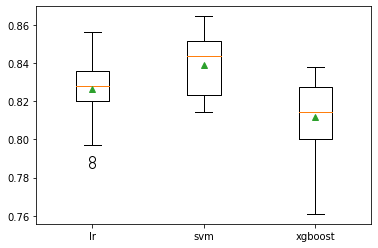

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import mean
from numpy import std

models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, x_full_data, y_full_data)
	results.append(scores)
	names.append(name)
	print('> Model: %s F1 score is %.2f, with a standard deviation of (%.2f)' % (name, scores.mean(), std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()